<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/SimCLR_finetuned_enmbeddings_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cloud-tpu-client==0.10 torch==1.8.1 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl tensorboard-plugin-profile

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl (145.0 MB)


In [3]:
!pip uninstall torch -y
!pip install torch==1.8.1

Found existing installation: torch 1.8.1
Uninstalling torch-1.8.1:
  Successfully uninstalled torch-1.8.1
  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.


In [4]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

from google.colab import auth, drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

In [5]:
import torch_xla.utils.serialization as xser

In [6]:
# Mount Drive
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import gdown

def download(data, url):
    # Download dataset
    import zipfile
    url = url
    output = "{}.zip".format(data)
    gdown.download(url, output, quiet=False)

    # Uncompress dataset
    local_zip = '{}.zip'.format(data)
    zip_ref = zipfile.ZipFile(local_zip, "r")
    zip_ref.extractall()
    zip_ref.close()

In [8]:
data_samples = {
    "sample@200": "https://drive.google.com/uc?id=1FfV7YyDJvNUCDP5r3-8iQfZ2-xJp_pgb",
    "sample@500": "https://drive.google.com/uc?id=1dHwUqpmSogEdjAB9rwDUL-OKFRUcVXte",
    "sample@1000": "https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2",
    "sample@2000": "https://drive.google.com/uc?id=1PB7uGd-dUnZKnKZpZl-HvE1DVcWgX50F",
    "sample@3000": "https://drive.google.com/uc?id=1_yre5K9YYvJgSrT4xvrI8eD_htucIywA",
    "sample@4000_images": "https://drive.google.com/uc?id=1dqVB8EozEpwWzyuU80AauoQmsiw3Gtm2",
    "sample@20000": "https://drive.google.com/uc?id=1MTDpLzpmhSiZq2jSdmHx2UDPn9FC8gzO",
    "val-voets-tf": "https://drive.google.com/uc?id=1VzVgMGTkBBPG2qbzLunD9HvLzH6tcyrv",
    "train_voets": "https://drive.google.com/uc?id=1AmcFh1MOOZ6aqKm2eO7XEdgmIEqHKTZ5",
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd"
}

In [9]:
LABELED = 'sample@1000'

In [12]:
URL_LABELED = data_samples[LABELED]
download(LABELED, URL_LABELED)

Downloading...
From: https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2
To: /content/sample@1000.zip
100%|██████████| 108M/108M [00:00<00:00, 135MB/s] 


In [17]:
!wget "https://raw.githubusercontent.com/pytorch/xla/master/test/args_parse.py"

--2022-02-14 00:03:41--  https://raw.githubusercontent.com/pytorch/xla/master/test/args_parse.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/plain]
Saving to: ‘args_parse.py’

args_parse.py       100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-02-14 00:03:42 (19.5 MB/s) - ‘args_parse.py’ saved [2036/2036]



In [18]:
import args_parse

SUPPORTED_MODELS = [
    'alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201',
    'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34',
    'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13',
    'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
]

MODEL_OPTS = {
    '--model': {
        'choices': SUPPORTED_MODELS,
        'default': 'resnet50',
    },
    '--test_set_batch_size': {
        'type': int,
    },
    '--lr_scheduler_type': {
        'type': str,
    },
    '--lr_scheduler_divide_every_n_epochs': {
        'type': int,
    },
    '--lr_scheduler_divisor': {
        'type': int,
    },
    '--test_only_at_end': {
        'action': 'store_true',
    },
}

In [19]:
FLAGS = args_parse.parse_common_options(
    datadir=LABELED,
    batch_size=None,
    num_epochs=None,
    momentum=None,
    lr=None,
    target_accuracy=None,
    profiler_port=9012,
    opts=MODEL_OPTS.items(),
)

In [20]:
EPOCHS = 200

In [21]:
FLAGS.fake_data = False
FLAGS.num_epochs = EPOCHS
FLAGS.batch_size = 64
FLAGS.log_steps = 100
FLAGS.num_cores = 8

## Test SimCLR

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils

In [15]:
def get_model_property(key):
  default_model_property = {
      'img_dim': 224,
      'model_fn': getattr(torchvision.models, FLAGS.model)
  }
  model_properties = {
      'inception_v3': {
          'img_dim': 299,
          'model_fn': lambda: torchvision.models.inception_v3(aux_logits=False)
      },
  }
  model_fn = model_properties.get(FLAGS.model, default_model_property)[key]
  return model_fn

In [22]:
device = xm.xla_device()
model = get_model_property('model_fn')().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.Linear(512, 1),
    nn.Sigmoid()
).to(device)

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
state_dict = xser.load('/content/drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-Finetuned-Test-{}.pt'.format(LABELED))
#state_dict = xser.load('/content/drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-Finetuned-Test.pt')

In [25]:
state_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.wei

In [26]:
for k in list(state_dict.keys()):
    if k.startswith('backbone.'):
        if k.startswith('backbone') and not k.startswith('backbone.fc'):
            # remove prefix
            state_dict[k[len("backbone."):]] = state_dict[k]
del state_dict[k]

In [27]:
log = model.load_state_dict(state_dict, strict=False)

In [28]:
log

_IncompatibleKeys(missing_keys=['fc.1.bias'], unexpected_keys=[])

In [29]:
import zipfile
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [39]:
test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

In [50]:
!gdown $URL_TEST_DATASET

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p 



In [42]:
local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [43]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [44]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # What happens if I change This 
])

In [45]:
test_dataset = datasets.ImageFolder(root="messidor2", transform=transform_val) # root: test/messidor2

In [46]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False)

loader = test_loader

In [47]:
y_true = []
y_pred = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            output = output.to(device)

            # Yo le agrege esto
            y_true.append(targets.cpu().detach().numpy()[0])
            y_pred.append(output.cpu().detach().numpy()[0][0])

            pbar.update(1)

100%|██████████| 1748/1748 [01:19<00:00, 22.12it/s]


In [48]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.8473607263773467

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


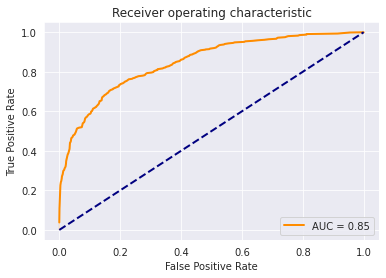

In [49]:
# Commented out IPython magic to ensure Python compatibility.
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
# %matplotlib inline

#cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
#print('AUC: %.3f' % auc)
#print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()